In [1]:
import numpy as np
from pathlib import Path

from pymor.basic import *
from pymor.core.pickle import load

from RBInvParam.problems.problems import build_InstationaryModelIP

set_log_levels({
    'pymor' : 'WARN'
})

set_defaults({})

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 10,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'figure.dpi': 400
})

In [3]:
WORK_DIR = Path('/run/media/benedikt/38E84473425D444F/Dokumente/Studium/Mathematik/PhD/parabolische_inverse_probleme')
#WORK_DIR = Path('/home/benedikt/Dokumente/parabolische_inverse_probleme')

method = 'TR_IRGNM'
dump_path = WORK_DIR / Path('examples/reaction/dumps') / f'20250404_180936_TR_IRGNM'
#dump_path = WORK_DIR / Path('experiments/high_acc_FOM') / f'reaction_FOM_500_time_dep_1e-9'
#dump_path = WORK_DIR / Path('experiments/enforce_adm_region_corrected_suff_cond') / f'diffusion_FOM_300_time_dep'

setup_path = dump_path / 'setup.pkl'
optimizer_parameter_path = dump_path / 'optimizer_parameter.pkl'
data_path = dump_path / f'{method}_final.pkl'
final_data_path = dump_path / f'{method}_final.pkl'

with open(setup_path, 'rb') as file:
    setup = load(file)

with open(optimizer_parameter_path, 'rb') as file:
    optimizer_parameter = load(file)

if not 'FOM' in locals():
    FOM, grid_data, _ = build_InstationaryModelIP(setup=setup)

q_exact = setup['model_parameter']['q_exact']

with open(data_path, 'rb') as file:
    data = load(file)


if final_data_path.exists():
    with open(final_data_path, 'rb') as file:
        final_data = load(file)

[2025-04-07 13:35:20,799][__init__] - Setting up InstationaryModelIP
[2025-04-07 13:35:23,274][discretize_instationary_IP] - noise percentage is 7.0703e-08
[2025-04-07 13:35:23,275][discretize_instationary_IP] - noise_level is 1.0000e-05
[2025-04-07 13:35:23,405][__init__] - Setting up InstationaryModelIP


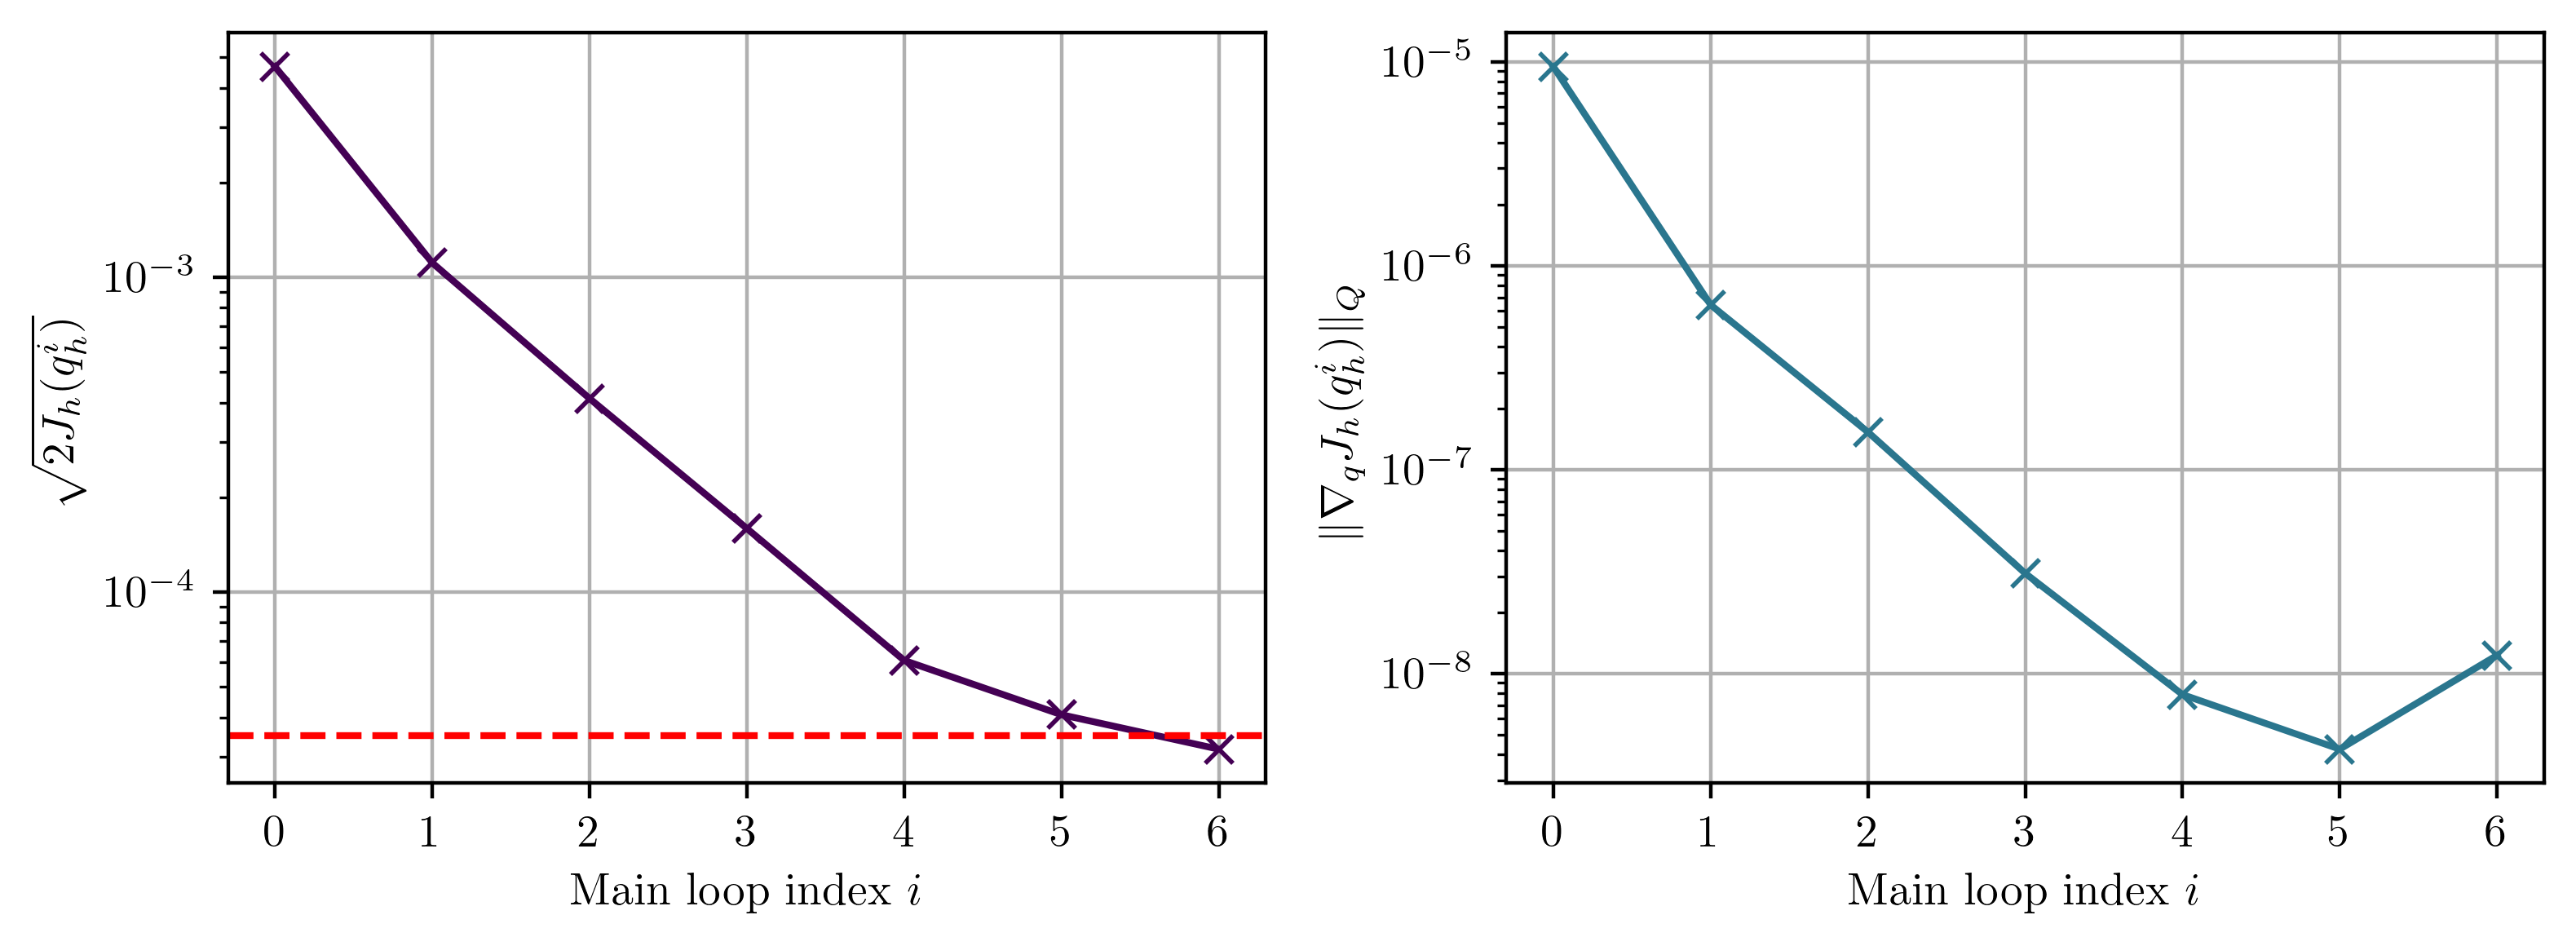

In [4]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
cmap = plt.get_cmap('viridis')

Js = np.array(data['J'])
norm_nabla_Js = np.array(data['norm_nabla_J'])
assert len(Js) == len(norm_nabla_Js)

ax[0].set_xlabel(r'$\textrm{Main loop index } i$')
ax[0].set_ylabel(r'$\sqrt{2J_h(q^i_h)}$')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].plot(np.sqrt(2 * Js), marker='x',color=cmap(0))

tau = optimizer_parameter['tau']
noise_level = optimizer_parameter['noise_level']
tol = optimizer_parameter['tol']
y = tau * noise_level + tol
ax[0].axhline(y=y, color='r', linestyle='--')


ax[1].set_xlabel(r'$\textrm{Main loop index } i$')
if setup['model_parameter']['q_time_dep']:
    ax[1].set_ylabel(r'$\|\nabla_q J_h(q^i_h)\|_{Q^{K}}$')
else:
    ax[1].set_ylabel(r'$\|\nabla_q J_h(q^i_h)\|_{Q}$')
    
ax[1].set_yscale('log')
ax[1].grid()
ax[1].plot(norm_nabla_Js, marker='x',color=cmap(100))
##############################


plt.tight_layout()
plt.show()

In [ ]:
val = data['q'][-1]
rel = q_exact

if setup['model_parameter']['q_time_dep']:
    x = FOM.products['bochner_prod_Q'].apply2(rel-val, rel-val)[0,0]
    y = FOM.products['bochner_prod_Q'].apply2(rel, rel)[0,0]
else:
    x = FOM.products['prod_Q'].apply2(rel-val, rel-val)[0,0]
    y = FOM.products['prod_Q'].apply2(rel, rel)[0,0]
    
z = np.sqrt(x) / np.sqrt(y) * 100
print(f"{z:3.4} %")

In [ ]:
#int(np.ceil(data['total_runtime']))

In [ ]:
#FOM.visualizer.visualize(FOM.setup['model_parameter']['q_exact'])
FOM.visualizer.visualize(q_exact)

In [ ]:
FOM.visualizer.visualize(data['q'][-1])

In [ ]:
FOM.visualizer.visualize(data['q'][-1] - setup['model_parameter']['q_exact'])

-2.5589019419528074
-1.0596408530191228
-2.991198962309885
-3.6250751651834507
-2.9477970437402714
-3.065409400482647
-5.424563123933767
-3.8586021357883697


/tmp/ipykernel_18649/3311541892.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


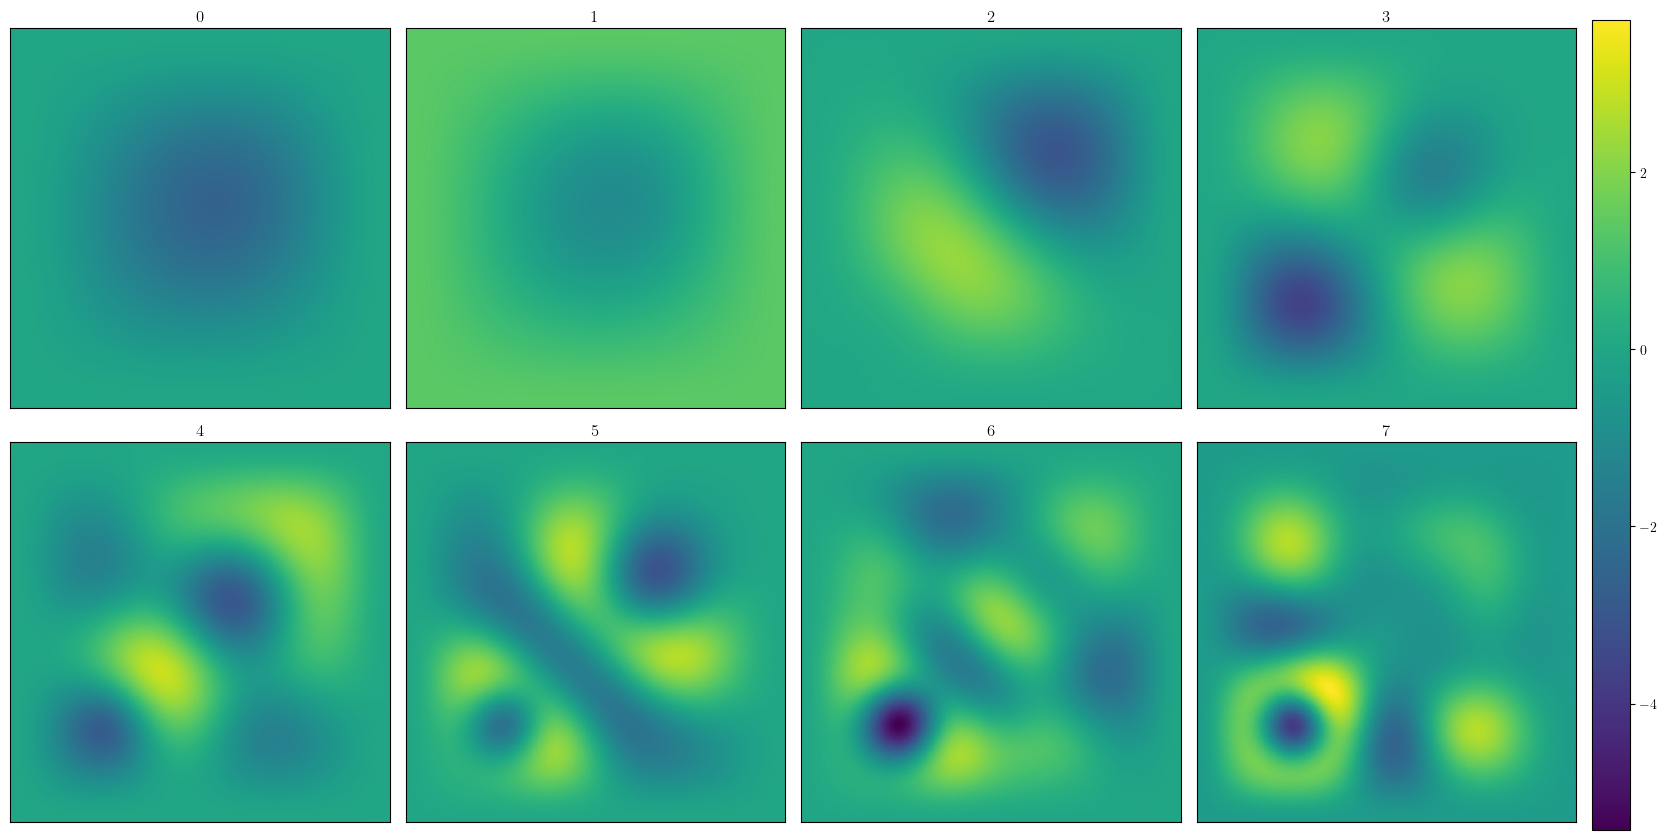

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import gridspec

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 10,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'figure.dpi': 100
})

def plot_q_diffs(data, ax, vmin, vmax):
    centers = grid_data['grid'].centers(codim=2)
    triang = tri.Triangulation(centers[:, 0], centers[:, 1])    
    return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)

# Get global color scale limits
all_data = [data['reduced_bases']['parameter_basis'][i].to_numpy()[0] for i in range(8)]
vmin = min(np.min(d) for d in all_data)
vmax = max(np.max(d) for d in all_data)
    
# Bigger figure to improve plot sizes
fig = plt.figure(figsize=(18, 9))

# Use GridSpec with minimal spacing and small colorbar width
gs = gridspec.GridSpec(2, 5, width_ratios=[1]*4 + [0.10], wspace=0.05, hspace=0.05)

# Plotting
axes = []
for i in range(8):
    row = i // 4
    col = i % 4
    ax = fig.add_subplot(gs[row, col])
    c = plot_q_diffs(data['reduced_bases']['parameter_basis'][i], ax, vmin, vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'{i}', pad=5)
    axes.append(ax)

# Colorbar (occupies the last column, right edge, vertically centered)
cbar_ax = fig.add_subplot(gs[:, -1])
fig.colorbar(c, cax=cbar_ax)

# Adjust margins to bring colorbar closer and plots larger
fig.subplots_adjust(left=0.04, right=0.94, top=0.95, bottom=0.05)

fig.show()
fig.savefig('./bases_2.png', bbox_inches='tight')


8.058896192370675
-4.114720780628136
8.058896192370675
-4.114720780628136
8.058896192370675
-4.114720780628136
8.058896192370675
-4.114720780628136
8.058896192370675
-4.114720780628136
8.058896192370675
-4.114720780628136


/tmp/ipykernel_18649/1299327259.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


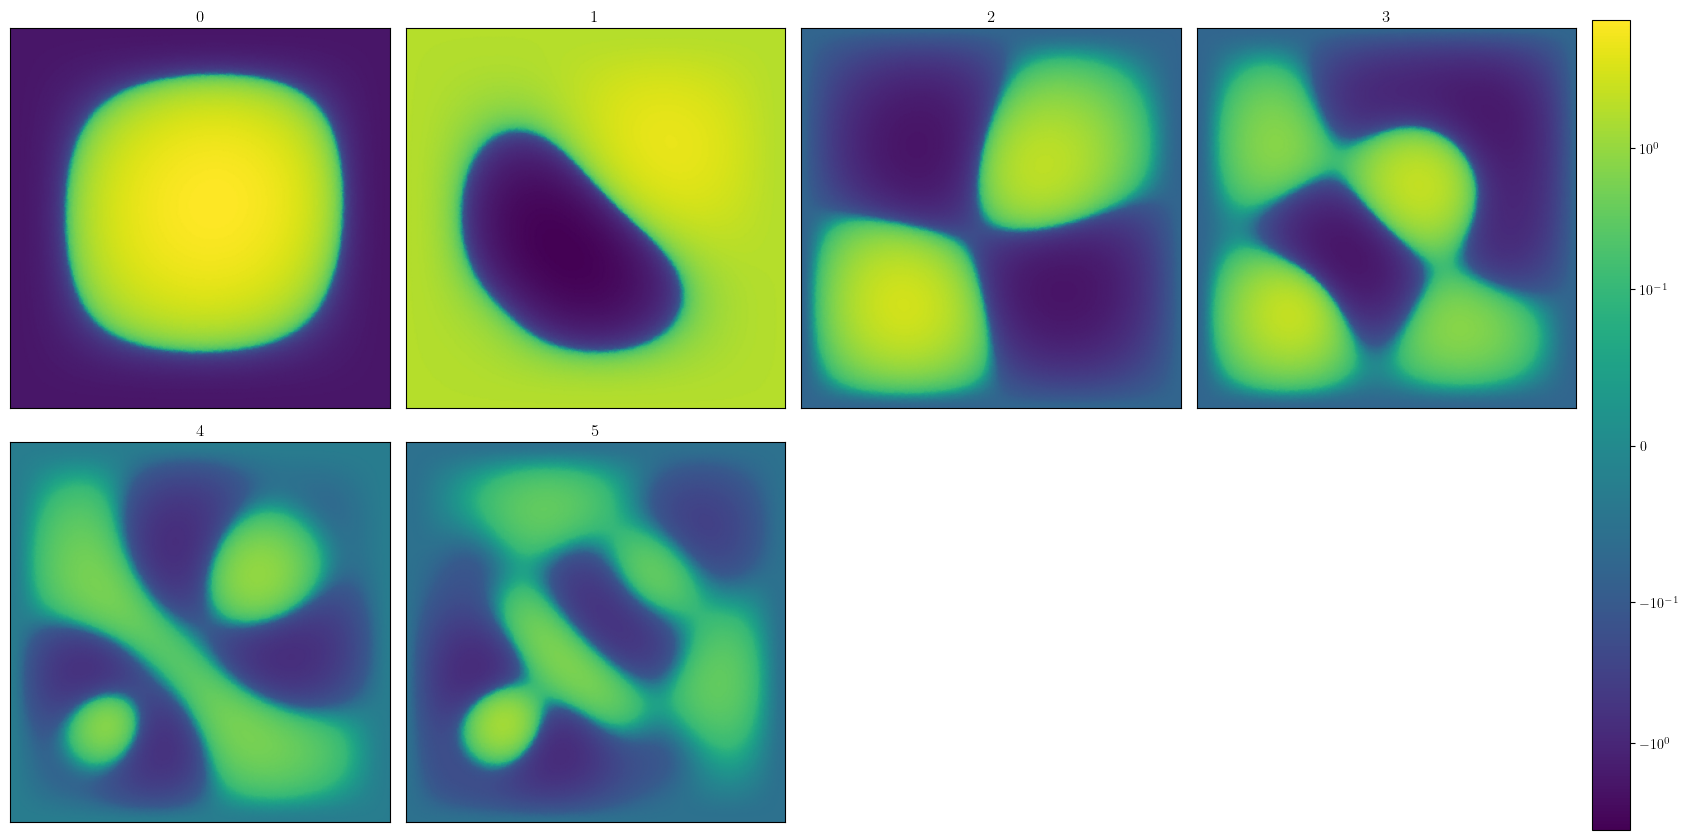

In [39]:
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# from matplotlib import gridspec
# from matplotlib.colors import SymLogNorm

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "cm",
#     "font.size": 10,
#     'text.latex.preamble': r'\usepackage{amsfonts}',
#     'figure.dpi': 100
# })

# def plot_q_diffs(data, ax, vmin, vmax):
#     centers = grid_data['grid'].centers(codim=2)
#     triang = tri.Triangulation(centers[:, 0], centers[:, 1])    
#     #return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)
#     #return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud')
#     print(vmax)
#     print(vmin)
#     norm = SymLogNorm(linthresh=1e-1, vmin=vmin, vmax=vmax)
#     return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud', norm=norm)
    

# # Get global color scale limits
# all_data = [(data['q'][i+1] - data['q'][i]).to_numpy()[0] for i in range(6)]
# vmin = min(np.min(d) for d in all_data)
# vmax = max(np.max(d) for d in all_data)
    
# # Bigger figure to improve plot sizes
# fig = plt.figure(figsize=(18, 9))

# # Use GridSpec with minimal spacing and small colorbar width
# gs = gridspec.GridSpec(2, 5, width_ratios=[1]*4 + [0.10], wspace=0.05, hspace=0.05)

# # Plotting
# axes = []
# for i in range(6):
#     row = i // 4
#     col = i % 4
#     ax = fig.add_subplot(gs[row, col])
#     diff = data['q'][i+1] - data['q'][i]
#     c = plot_q_diffs(diff, ax, vmin, vmax)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_aspect('equal')
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.set_title(f'{i}', pad=5)
#     axes.append(ax)

# # Colorbar (occupies the last column, right edge, vertically centered)
# cbar_ax = fig.add_subplot(gs[:, -1])
# fig.colorbar(c, cax=cbar_ax)

# # Adjust margins to bring colorbar closer and plots larger
# fig.subplots_adjust(left=0.04, right=0.94, top=0.95, bottom=0.05)

# fig.show()
# #fig.savefig('./bases_2.png', bbox_inches='tight')

/tmp/ipykernel_18649/3281017381.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


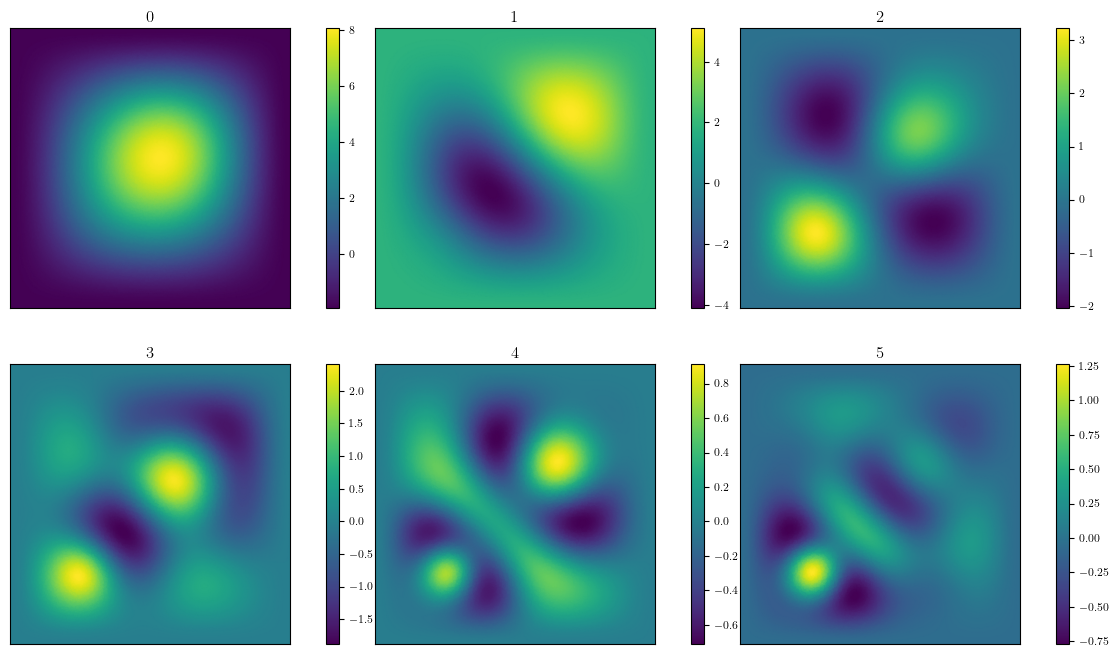

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import gridspec

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 10,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'figure.dpi': 100
})

def plot_q_diffs(data, ax, vmin=None, vmax=None):
    centers = grid_data['grid'].centers(codim=2)
    triang = tri.Triangulation(centers[:, 0], centers[:, 1])    
    return ax.tripcolor(triang, data.to_numpy()[0], cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)

# Figure and GridSpec with narrow colorbar columns
fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.04]*3, wspace=0.06)

for i in range(6):
    row = i // 3
    col_plot = (i % 3) * 2
    col_cbar = col_plot + 1

    # Plot axis
    ax = fig.add_subplot(gs[row, col_plot])
    diff = data['q'][i+1] - data['q'][i]
    c = plot_q_diffs(diff, ax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'{i}', pad=5)

    # Narrow colorbar axis
    cbar_ax = fig.add_subplot(gs[row, col_cbar])
    fig.colorbar(c, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=8)

#fig.subplots_adjust(left=0.03, right=0.97, top=0.95, bottom=0.08)
fig.show()
# fig.savefig('./bases_individual_slimbars.png', bbox_inches='tight')


7